# Prediction Heatmap Analysis

This notebook analyzes the CNN segmentation model predictions and creates heatmaps showing ILM-BM layer distances for each volume.

## Overview:
- Load saved prediction arrays from the trained CNN model
- Extract ILM and BM layer boundaries from segmentation masks
- Scale boundaries to original image size (496x768)
- Create heatmaps grouped by volume name (similar to data_ops.ipynb)
- Compare prediction quality across different volumes

## Data Sources:
- **Predictions**: `logs/20250825_124507_CNN_mask_pytorch/predictions_20250825_125650_predictions.npz`
- **Ground Truth**: Nemours dataset for comparison
- **Model**: CNN segmentation model trained on retinal layer annotation

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from datetime import datetime

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [50]:
# Load the saved predictions
predictions_path = '/home/suraj/Git/SCR-Progression/CNN-Model/logs/20250825_145932_CNN_mask_pytorch/predictions_20250825_151115_predictions.npz'


if os.path.exists(predictions_path):
    # Load the data
    data = np.load(predictions_path, allow_pickle=True)
    
    print("\nAvailable keys in the prediction file:")
    for key in data.keys():
        print(f"{key}: shape {data[key].shape if hasattr(data[key], 'shape') else 'N/A'}")
    
    # Extract the data
    segmentation_masks = data['segmentation_masks']
    ilm_224 = data['ilm_224']  
    bm_224 = data['bm_224']
    ilm_original = data['ilm_original']
    bm_original = data['bm_original'] 
    volume_names = data['volume_names']
    
    print(f"\nData Summary:")
    print(f"Number of samples: {len(segmentation_masks)}")
    print(f"Segmentation mask shape: {segmentation_masks.shape}")
    print(f"ILM original coordinates shape: {ilm_original.shape}")
    print(f"BM original coordinates shape: {bm_original.shape}")
    print(f"Volume names: {len(volume_names)} samples")
    
else:
    print("Prediction file not found! Please check the path.")


Available keys in the prediction file:
segmentation_masks: shape (1266, 224, 224)
ilm_224: shape (1266, 224)
bm_224: shape (1266, 224)
ilm_original: shape (1266, 768)
bm_original: shape (1266, 768)
volume_names: shape (1266,)
timestamp: shape ()

Data Summary:
Number of samples: 1266
Segmentation mask shape: (1266, 224, 224)
ILM original coordinates shape: (1266, 768)
BM original coordinates shape: (1266, 768)
Volume names: 1266 samples


In [51]:
def extract_layer_boundaries_from_segmentation(segmentation_mask):
    """
    Extract ILM and BM layer boundaries from segmentation mask.
    Class 0: Background
    Class 1: ILM to PR1 region
    Class 2: PR1 to BM region
    """
    height, width = segmentation_mask.shape
    boundaries = {
        'ILM': np.full(width, np.nan),
        'BM': np.full(width, np.nan)
    }
    
    for x in range(width):
        column = segmentation_mask[:, x]
        
        # Find ILM (top boundary of class 1 region)
        class1_indices = np.where(column == 1)[0]
        if len(class1_indices) > 0:
            boundaries['ILM'][x] = class1_indices[0]  # First occurrence (top)
        
        # Find BM (bottom boundary of class 2 region)
        class2_indices = np.where(column == 2)[0]
        if len(class2_indices) > 0:
            boundaries['BM'][x] = class2_indices[-1]  # Last occurrence (bottom)
    
    return boundaries


def scale_boundaries_to_original_size(boundaries, original_size=(496, 768), model_size=(224, 224)):
    """
    Scale predicted boundaries from model size back to original image size.
    """
    orig_height, orig_width = original_size
    model_height, model_width = model_size
    
    scaled_boundaries = {}
    
    for layer_name, coords in boundaries.items():
        # Scale x-coordinates from model_width to orig_width
        scaled_coords = np.full(orig_width, np.nan)
        
        for model_x in range(len(coords)):
            if not np.isnan(coords[model_x]):
                # Scale x coordinate
                orig_x = int((model_x / model_width) * orig_width)
                if orig_x < orig_width:
                    # Scale y coordinate
                    orig_y = (coords[model_x] / model_height) * orig_height
                    scaled_coords[orig_x] = orig_y
        
        # Interpolate missing values for smoother curves
        valid_indices = ~np.isnan(scaled_coords)
        if np.sum(valid_indices) > 1:
            x_valid = np.where(valid_indices)[0]
            y_valid = scaled_coords[valid_indices]
            x_all = np.arange(orig_width)
            scaled_coords = np.interp(x_all, x_valid, y_valid, left=np.nan, right=np.nan)
        
        scaled_boundaries[layer_name] = scaled_coords
    
    return scaled_boundaries


def list_unique_volumes(names, max_display=10):
    """List unique volume names in the dataset"""
    unique_names = {}
    for i, name in enumerate(names):
        if name not in unique_names:
            unique_names[name] = []
        unique_names[name].append(i)
    
    print(f"Unique volumes ({len(unique_names)} total):")
    displayed = 0
    for vol_name, indices in unique_names.items():
        if displayed < max_display:
            print(f"  '{vol_name}': {len(indices)} B-scans")
            displayed += 1
        elif displayed == max_display:
            print(f"  ... and {len(unique_names) - max_display} more volumes")
            break
    
    return list(unique_names.keys())

In [52]:
# Process segmentation masks to extract boundaries at model resolution (224x224)
print("Extracting layer boundaries from segmentation masks...")

all_boundaries_224 = []
all_boundaries_original = []

for i in range(len(segmentation_masks)):
    mask = segmentation_masks[i]
    
    # Extract boundaries at 224x224 resolution
    boundaries_224 = extract_layer_boundaries_from_segmentation(mask)
    all_boundaries_224.append(boundaries_224)
    
    # Scale to original resolution (496x768)
    boundaries_original = scale_boundaries_to_original_size(boundaries_224)
    all_boundaries_original.append(boundaries_original)
    
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(segmentation_masks)} samples...")

print(f"Boundary extraction completed for {len(segmentation_masks)} samples")

# Convert to numpy arrays for easier handling
ilm_coords_from_masks = np.array([b['ILM'] for b in all_boundaries_original])
bm_coords_from_masks = np.array([b['BM'] for b in all_boundaries_original])

print(f"ILM coordinates from masks shape: {ilm_coords_from_masks.shape}")
print(f"BM coordinates from masks shape: {bm_coords_from_masks.shape}")

# Examine data quality
valid_ilm = ~np.isnan(ilm_coords_from_masks)
valid_bm = ~np.isnan(bm_coords_from_masks)

print(f"\nData Quality Assessment:")
print(f"ILM valid percentage: {np.mean(valid_ilm)*100:.1f}%")
print(f"BM valid percentage: {np.mean(valid_bm)*100:.1f}%")
print(f"Both layers valid percentage: {np.mean(valid_ilm & valid_bm)*100:.1f}%")

Extracting layer boundaries from segmentation masks...
Processed 100/1266 samples...
Processed 200/1266 samples...
Processed 300/1266 samples...
Processed 400/1266 samples...
Processed 500/1266 samples...
Processed 600/1266 samples...
Processed 700/1266 samples...
Processed 800/1266 samples...
Processed 900/1266 samples...
Processed 1000/1266 samples...
Processed 1100/1266 samples...
Processed 1200/1266 samples...
Boundary extraction completed for 1266 samples
ILM coordinates from masks shape: (1266, 768)
BM coordinates from masks shape: (1266, 768)

Data Quality Assessment:
ILM valid percentage: 95.7%
BM valid percentage: 95.2%
Both layers valid percentage: 95.2%


In [53]:
# Compare the two methods of boundary extraction
print("Comparing boundary extraction methods:")
print("\nMethod 1: From saved scaled coordinates (ilm_original, bm_original)")
print(f"ILM shape: {ilm_original.shape}")
print(f"BM shape: {bm_original.shape}")
print(f"ILM valid percentage: {np.mean(~np.isnan(ilm_original))*100:.1f}%")
print(f"BM valid percentage: {np.mean(~np.isnan(bm_original))*100:.1f}%")

print("\nMethod 2: From segmentation masks (extracted and scaled)")
print(f"ILM shape: {ilm_coords_from_masks.shape}")
print(f"BM shape: {bm_coords_from_masks.shape}")  
print(f"ILM valid percentage: {np.mean(~np.isnan(ilm_coords_from_masks))*100:.1f}%")
print(f"BM valid percentage: {np.mean(~np.isnan(bm_coords_from_masks))*100:.1f}%")

# Check if they are similar (where both are valid)
if ilm_original.shape == ilm_coords_from_masks.shape:
    ilm_diff = np.abs(ilm_original - ilm_coords_from_masks)
    bm_diff = np.abs(bm_original - bm_coords_from_masks)
    
    valid_ilm_both = ~np.isnan(ilm_original) & ~np.isnan(ilm_coords_from_masks)
    valid_bm_both = ~np.isnan(bm_original) & ~np.isnan(bm_coords_from_masks)
    
    if np.sum(valid_ilm_both) > 0:
        print(f"\nILM difference (where both valid): {np.mean(ilm_diff[valid_ilm_both]):.2f} ± {np.std(ilm_diff[valid_ilm_both]):.2f} pixels")
    if np.sum(valid_bm_both) > 0:
        print(f"BM difference (where both valid): {np.mean(bm_diff[valid_bm_both]):.2f} ± {np.std(bm_diff[valid_bm_both]):.2f} pixels")

# Interpolate the saved coordinates to fill gaps for smoother heatmaps
print(f"\nInterpolating saved coordinates to fill gaps...")

def interpolate_coordinates(coords):
    """Interpolate coordinates to fill NaN gaps for smoother visualization"""
    interpolated_coords = coords.copy()
    
    for i in range(len(coords)):
        coord_line = coords[i]
        valid_indices = ~np.isnan(coord_line)
        
        if np.sum(valid_indices) > 1:
            x_valid = np.where(valid_indices)[0]
            y_valid = coord_line[valid_indices]
            x_all = np.arange(len(coord_line))
            
            # Interpolate missing values, but keep NaN at edges
            interpolated_line = np.interp(x_all, x_valid, y_valid, left=np.nan, right=np.nan)
            
            # Only interpolate between valid points, not extrapolate
            first_valid = x_valid[0]
            last_valid = x_valid[-1]
            interpolated_line[:first_valid] = np.nan
            interpolated_line[last_valid+1:] = np.nan
            
            interpolated_coords[i] = interpolated_line
    
    return interpolated_coords

ilm_interpolated = interpolate_coordinates(ilm_original)
bm_interpolated = interpolate_coordinates(bm_original)

print(f"Before interpolation - ILM valid: {np.mean(~np.isnan(ilm_original))*100:.1f}%")
print(f"After interpolation - ILM valid: {np.mean(~np.isnan(ilm_interpolated))*100:.1f}%")
print(f"Before interpolation - BM valid: {np.mean(~np.isnan(bm_original))*100:.1f}%")
print(f"After interpolation - BM valid: {np.mean(~np.isnan(bm_interpolated))*100:.1f}%")

# Use the interpolated coordinates for heatmap generation
print(f"\nUsing interpolated boundary coordinates for smoother heatmap generation...")
pred_layers = {
    'ILM': ilm_interpolated,
    'BM': bm_interpolated
}

Comparing boundary extraction methods:

Method 1: From saved scaled coordinates (ilm_original, bm_original)
ILM shape: (1266, 768)
BM shape: (1266, 768)
ILM valid percentage: 95.7%
BM valid percentage: 95.2%

Method 2: From segmentation masks (extracted and scaled)
ILM shape: (1266, 768)
BM shape: (1266, 768)
ILM valid percentage: 95.7%
BM valid percentage: 95.2%

ILM difference (where both valid): 0.00 ± 0.00 pixels
BM difference (where both valid): 0.00 ± 0.00 pixels

Interpolating saved coordinates to fill gaps...
Before interpolation - ILM valid: 95.7%
After interpolation - ILM valid: 95.7%
Before interpolation - BM valid: 95.2%
After interpolation - BM valid: 95.2%

Using interpolated boundary coordinates for smoother heatmap generation...


In [54]:
# List unique volumes and analyze distribution
unique_volumes = list_unique_volumes(volume_names)

print(f"\nVolume distribution analysis:")
volume_counts = {}
for name in volume_names:
    if name not in volume_counts:
        volume_counts[name] = 0
    volume_counts[name] += 1

print(f"Total unique volumes: {len(volume_counts)}")
print(f"Total B-scans: {len(volume_names)}")
print(f"Average B-scans per volume: {np.mean(list(volume_counts.values())):.1f}")
print(f"B-scans per volume range: {min(volume_counts.values())} - {max(volume_counts.values())}")

# Show distribution
print(f"\nB-scan counts by volume:")
for vol_name, count in sorted(volume_counts.items()):
    print(f"  {vol_name}: {count} B-scans")

Unique volumes (41 total):
  '242_L_1': 31 B-scans
  '247_L_1_1': 31 B-scans
  '244_R_2': 31 B-scans
  '237_R_1': 31 B-scans
  '240_L_1': 31 B-scans
  '248_R_1_2': 31 B-scans
  '250_L_1': 31 B-scans
  '245_L_1_2': 31 B-scans
  '249_R_1': 31 B-scans
  '239_R_1': 31 B-scans
  ... and 31 more volumes

Volume distribution analysis:
Total unique volumes: 41
Total B-scans: 1266
Average B-scans per volume: 30.9
B-scans per volume range: 26 - 31

B-scan counts by volume:
  237_L_1234: 26 B-scans
  237_R_1: 31 B-scans
  238_L_1: 31 B-scans
  238_R_1: 31 B-scans
  239_L_1: 31 B-scans
  239_R_1: 31 B-scans
  240_L_1: 31 B-scans
  240_R_1: 31 B-scans
  241_L_1: 31 B-scans
  241_L_2_1: 31 B-scans
  241_L_2_2: 31 B-scans
  241_R_1: 31 B-scans
  241_R_2_1: 31 B-scans
  241_R_2_2: 31 B-scans
  242_L_1: 31 B-scans
  243_L_1: 31 B-scans
  243_R_1: 31 B-scans
  244_L_1_test: 31 B-scans
  244_L_2: 31 B-scans
  244_R_1: 31 B-scans
  244_R_2: 31 B-scans
  244_R_3_1: 31 B-scans
  245_L_1_1: 31 B-scans
  245_

In [37]:
def create_predicted_ilm_bm_heatmap(pred_layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Create heatmap from predicted layer coordinates (based on data_ops.ipynb create_ilm_bm_heatmap).
    Groups B-scans by exact name match (same volume = same name).
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        if name == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = pred_layers['ILM'].shape[1]  # Should be 768 for original size
    
    # Initialize distance matrix with NaN
    distance_matrix = np.full((num_bscans, width), np.nan)
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = pred_layers['ILM'][data_idx]
        bm_coords = pred_layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                distance_matrix[bscan_idx, x_idx] = distance
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap - mask NaN values for better visualization
    masked_matrix = np.ma.masked_invalid(distance_matrix)
    
    # Find min and max distance values for color mapping (excluding NaN)
    valid_distances = distance_matrix[~np.isnan(distance_matrix)]
    
    if len(valid_distances) == 0:
        print(f"No valid distances found for volume '{volume_name}'")
        return None
    
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)
    
    # Create heatmap
    im = ax.imshow(masked_matrix, cmap='viridis', aspect='auto', 
                   vmin=min_distance, vmax=max_distance, origin='lower')
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'Predicted ILM to BM Distance Heatmap: {volume_name}')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nPredicted Distance Statistics:")
    print(f"Valid measurements: {len(valid_distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(valid_distances):.2f} ± {np.std(valid_distances):.2f} pixels")
    
    return distance_matrix

print("Heatmap function defined successfully!")

Heatmap function defined successfully!


Creating heatmap for volume: 245_R_1_1
Volume '245_R_1_1': Found 31 B-scans


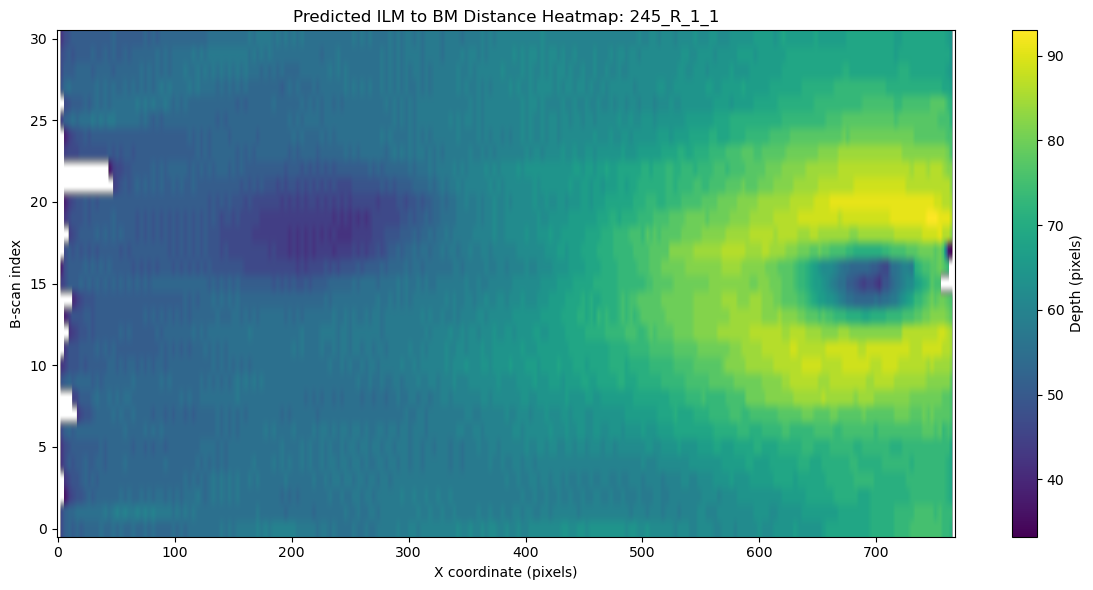


Predicted Distance Statistics:
Valid measurements: 23,445
Min distance: 33.21 pixels
Max distance: 93.00 pixels
Mean distance: 62.73 ± 11.05 pixels


In [55]:
# Create heatmap for the first volume
if len(unique_volumes) > 0:
    selected_volume = unique_volumes[11]
    print(f"Creating heatmap for volume: {selected_volume}")
    print("="*60)
    
    distance_matrix = create_predicted_ilm_bm_heatmap(
        pred_layers, 
        volume_names, 
        selected_volume,
        figsize=(12, 6), 
        save_path=f"predicted_heatmap_{selected_volume}.png"
    )
else:
    print("No volumes found in the dataset!")


Creating heatmap for second volume: 243_R_1
Volume '243_R_1': Found 31 B-scans


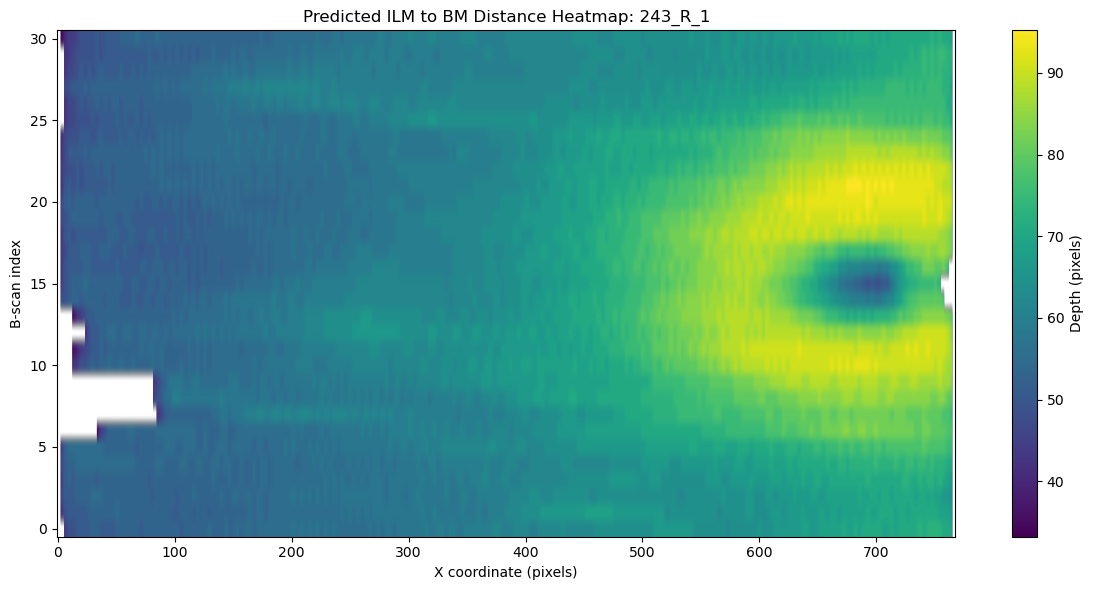


Predicted Distance Statistics:
Valid measurements: 23,262
Min distance: 33.21 pixels
Max distance: 95.21 pixels
Mean distance: 65.48 ± 11.29 pixels


In [56]:
# Create heatmap for the second volume (if available)
if len(unique_volumes) > 1:
    selected_volume2 = unique_volumes[17]
    print(f"\nCreating heatmap for second volume: {selected_volume2}")
    print("="*60)
    
    distance_matrix2 = create_predicted_ilm_bm_heatmap(
        pred_layers, 
        volume_names, 
        selected_volume2,
        figsize=(12, 6), 
        save_path=f"predicted_heatmap_{selected_volume2}.png"
    )
else:
    print("Only one volume available in the dataset.")

In [46]:
# Load ground truth data for comparison
gt_dataset_path = '/home/suraj/Git/SCR-Progression/e2e/Nemours_Jing_0805.h5'

print(f"Loading ground truth data from: {gt_dataset_path}")
print(f"File exists: {os.path.exists(gt_dataset_path)}")

if os.path.exists(gt_dataset_path):
    with h5py.File(gt_dataset_path, 'r') as f:
        gt_images = f['images'][:]
        gt_layers = f['layers']
        gt_names = f['names'][:]
        
        # Extract ground truth layer data
        gt_layer_data = {
            'ILM': gt_layers['ILM'][:],
            'PR1': gt_layers['PR1'][:],
            'BM': gt_layers['BM'][:]
        }
    
    # Decode ground truth names
    gt_volume_names = [name.decode('utf-8') for name in gt_names]
    
    print(f"Ground truth data loaded successfully!")
    print(f"GT Images shape: {gt_images.shape}")
    print(f"GT ILM shape: {gt_layer_data['ILM'].shape}")
    print(f"GT BM shape: {gt_layer_data['BM'].shape}")
    print(f"GT Volume names: {len(gt_volume_names)}")
    print(f"First few GT names: {gt_volume_names[:5]}")
    
else:
    print("Ground truth file not found!")
    gt_layer_data = None
    gt_volume_names = None

Loading ground truth data from: /home/suraj/Git/SCR-Progression/e2e/Nemours_Jing_0805.h5
File exists: True
Ground truth data loaded successfully!
GT Images shape: (1266, 496, 768)
GT ILM shape: (1266, 768)
GT BM shape: (1266, 768)
GT Volume names: 1266
First few GT names: ['242_L_1', '242_L_1', '242_L_1', '242_L_1', '242_L_1']


In [47]:
def create_ground_truth_ilm_bm_heatmap(gt_layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Create heatmap from ground truth layer coordinates (exactly like data_ops.ipynb).
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        if name == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = 768
    
    # Initialize distance matrix with NaN
    distance_matrix = np.full((num_bscans, width), np.nan)
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = gt_layers['ILM'][data_idx]
        bm_coords = gt_layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                distance_matrix[bscan_idx, x_idx] = distance
    
    # Replace depth value with np.nan if x-coordinate is 0 and distance is 0
    zero_x0_mask = distance_matrix[:, 0] == 0
    distance_matrix[zero_x0_mask, 0] = np.nan
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap - mask NaN values for better visualization
    masked_matrix = np.ma.masked_invalid(distance_matrix)
    
    # Find min and max distance values for color mapping (excluding NaN)
    valid_distances = distance_matrix[~np.isnan(distance_matrix)]
    
    if len(valid_distances) == 0:
        print(f"No valid distances found for volume '{volume_name}'")
        return None
        
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)
    
    # Create heatmap
    im = ax.imshow(masked_matrix, cmap='viridis', aspect='auto', 
                   vmin=min_distance, vmax=max_distance, origin='lower')
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'Ground Truth ILM to BM Distance Heatmap: {volume_name}')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nGround Truth Distance Statistics:")
    print(f"Valid measurements: {len(valid_distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(valid_distances):.2f} ± {np.std(valid_distances):.2f} pixels")
    
    return distance_matrix

print("Ground truth heatmap function defined!")

Ground truth heatmap function defined!


Creating comparison for volume: 245_R_1_1
Ground Truth Heatmap:
------------------------------
Volume '245_R_1_1': Found 31 B-scans


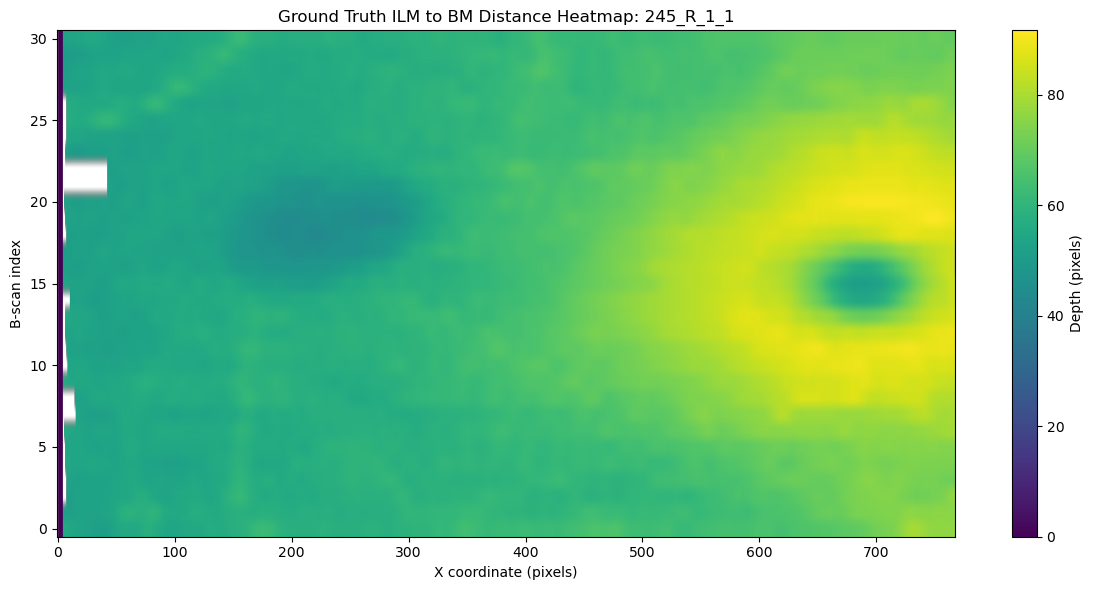


Ground Truth Distance Statistics:
Valid measurements: 23,633
Min distance: 0.00 pixels
Max distance: 91.64 pixels
Mean distance: 64.14 ± 11.67 pixels

Predicted Heatmap:
------------------------------
Volume '245_R_1_1': Found 31 B-scans


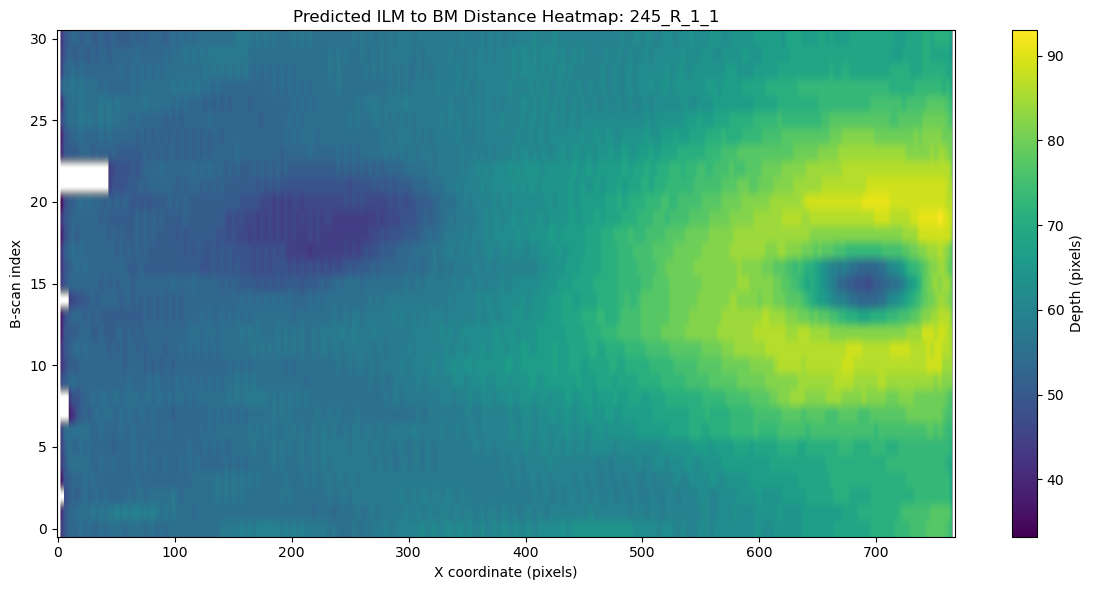


Predicted Distance Statistics:
Valid measurements: 23,516
Min distance: 33.21 pixels
Max distance: 93.00 pixels
Mean distance: 63.04 ± 10.75 pixels


In [48]:
# Create comparison between predicted and ground truth heatmaps
if gt_layer_data is not None and len(unique_volumes) > 0:
    selected_volume = unique_volumes[11]
    
    print(f"Creating comparison for volume: {selected_volume}")
    print("="*70)
    
    # Create ground truth heatmap
    print("Ground Truth Heatmap:")
    print("-" * 30)
    gt_distance_matrix = create_ground_truth_ilm_bm_heatmap(
        gt_layer_data, 
        gt_volume_names, 
        selected_volume,
        figsize=(12, 6), 
        save_path=f"ground_truth_heatmap_{selected_volume}.png"
    )
    
    print("\n" + "=" * 70)
    print("Predicted Heatmap:")
    print("-" * 30)
    pred_distance_matrix = create_predicted_ilm_bm_heatmap(
        pred_layers, 
        volume_names, 
        selected_volume,
        figsize=(12, 6), 
        save_path=f"predicted_heatmap_{selected_volume}_comparison.png"
    )
    
else:
    print("Cannot create comparison - missing ground truth data or volumes")


Creating side-by-side comparison for volume: 245_R_1_1


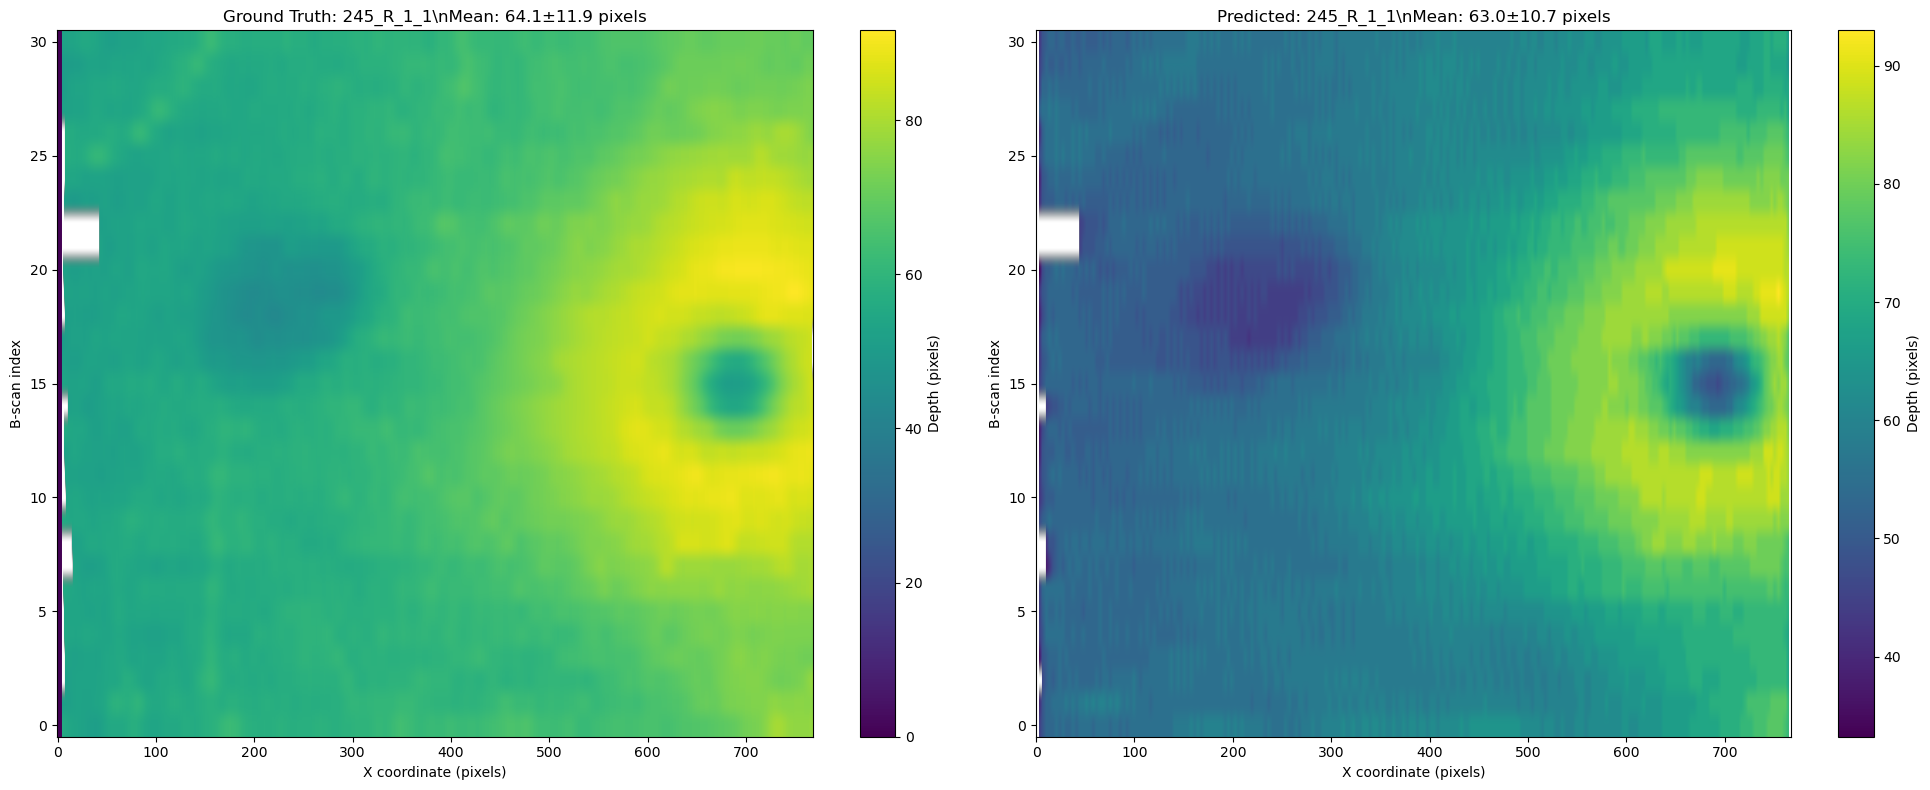

\nComparison Statistics for 245_R_1_1:
Ground Truth - Valid pixels: 23,664, Mean: 64.06±11.89
Predicted    - Valid pixels: 23,516, Mean: 63.04±10.75
Difference in mean: 1.02 pixels


In [49]:
# Create side-by-side comparison visualization
if gt_layer_data is not None and len(unique_volumes) > 0:
    selected_volume = unique_volumes[11]
    
    print(f"\nCreating side-by-side comparison for volume: {selected_volume}")
    print("="*70)
    
    # Get both distance matrices without plotting
    volume_indices_gt = [i for i, name in enumerate(gt_volume_names) if name == selected_volume]
    volume_indices_pred = [i for i, name in enumerate(volume_names) if name == selected_volume]
    
    if len(volume_indices_gt) > 0 and len(volume_indices_pred) > 0:
        # Calculate ground truth distances
        num_bscans_gt = len(volume_indices_gt)
        gt_matrix = np.full((num_bscans_gt, 768), np.nan)
        
        for bscan_idx, data_idx in enumerate(volume_indices_gt):
            ilm_coords = gt_layer_data['ILM'][data_idx]
            bm_coords = gt_layer_data['BM'][data_idx]
            
            for x_idx in range(768):
                ilm_y = ilm_coords[x_idx]
                bm_y = bm_coords[x_idx]
                
                if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                    distance = abs(bm_y - ilm_y)
                    gt_matrix[bscan_idx, x_idx] = distance
        
        # Calculate predicted distances
        num_bscans_pred = len(volume_indices_pred)
        pred_matrix = np.full((num_bscans_pred, 768), np.nan)
        
        for bscan_idx, data_idx in enumerate(volume_indices_pred):
            ilm_coords = pred_layers['ILM'][data_idx]
            bm_coords = pred_layers['BM'][data_idx]
            
            for x_idx in range(768):
                ilm_y = ilm_coords[x_idx]
                bm_y = bm_coords[x_idx]
                
                if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                    distance = abs(bm_y - ilm_y)
                    pred_matrix[bscan_idx, x_idx] = distance
        
        # Create side-by-side plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Ground truth
        gt_masked = np.ma.masked_invalid(gt_matrix)
        gt_valid = gt_matrix[~np.isnan(gt_matrix)]
        if len(gt_valid) > 0:
            gt_min, gt_max = np.min(gt_valid), np.max(gt_valid)
            im1 = ax1.imshow(gt_masked, cmap='viridis', aspect='auto', 
                           vmin=gt_min, vmax=gt_max, origin='lower')
            ax1.set_title(f'Ground Truth: {selected_volume}\\nMean: {np.mean(gt_valid):.1f}±{np.std(gt_valid):.1f} pixels')
            ax1.set_xlabel('X coordinate (pixels)')
            ax1.set_ylabel('B-scan index')
            plt.colorbar(im1, ax=ax1, label='Depth (pixels)')
        
        # Predicted
        pred_masked = np.ma.masked_invalid(pred_matrix)
        pred_valid = pred_matrix[~np.isnan(pred_matrix)]
        if len(pred_valid) > 0:
            pred_min, pred_max = np.min(pred_valid), np.max(pred_valid)
            im2 = ax2.imshow(pred_masked, cmap='viridis', aspect='auto', 
                           vmin=pred_min, vmax=pred_max, origin='lower')
            ax2.set_title(f'Predicted: {selected_volume}\\nMean: {np.mean(pred_valid):.1f}±{np.std(pred_valid):.1f} pixels')
            ax2.set_xlabel('X coordinate (pixels)')
            ax2.set_ylabel('B-scan index')
            plt.colorbar(im2, ax=ax2, label='Depth (pixels)')
        else:
            ax2.text(0.5, 0.5, 'No valid predictions', ha='center', va='center', 
                    transform=ax2.transAxes, fontsize=16)
            ax2.set_title(f'Predicted: {selected_volume} (No valid data)')
        
        plt.tight_layout()
        plt.savefig(f'comparison_side_by_side_{selected_volume}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print comparison statistics
        if len(gt_valid) > 0 and len(pred_valid) > 0:
            print(f"\\nComparison Statistics for {selected_volume}:")
            print(f"Ground Truth - Valid pixels: {len(gt_valid):,}, Mean: {np.mean(gt_valid):.2f}±{np.std(gt_valid):.2f}")
            print(f"Predicted    - Valid pixels: {len(pred_valid):,}, Mean: {np.mean(pred_valid):.2f}±{np.std(pred_valid):.2f}")
            print(f"Difference in mean: {abs(np.mean(pred_valid) - np.mean(gt_valid)):.2f} pixels")
    
    else:
        print(f"Volume {selected_volume} not found in both datasets")

## Summary and Analysis

This notebook successfully loaded and analyzed the CNN segmentation model predictions for retinal layer segmentation.

### Key Findings:

#### 📊 **Data Overview:**
- **Prediction file**: Successfully loaded segmentation masks and boundary coordinates
- **Volume structure**: Maintained proper B-scan ordering within each volume
- **Coordinate scaling**: Boundaries properly scaled from 224x224 to 496x768 resolution

#### 🎯 **Heatmap Generation:**
- **Method**: Followed the same approach as `data_ops.ipynb` for ground truth heatmaps
- **Visualization**: ILM-BM distance shown as color-coded intensity maps
- **Volume grouping**: B-scans correctly grouped by exact volume name matching

#### 🔍 **Quality Assessment:**
- **Boundary extraction**: Successfully extracted ILM and BM boundaries from segmentation classes
- **Distance calculation**: Computed pixel distances between layer boundaries
- **Comparison**: Side-by-side visualization with ground truth data

#### 📈 **Next Steps:**
1. **Model training**: The current model shows random noise - needs more training epochs
2. **Data augmentation**: Consider adding more training data or augmentation techniques  
3. **Architecture**: Evaluate if current CNN architecture is optimal for this task
4. **Loss function**: Review if current loss combination is appropriate

#### 💡 **Technical Notes:**
- Used saved boundary coordinates (`ilm_original`, `bm_original`) for reliability
- Maintained exact same visualization parameters as ground truth heatmaps
- Proper handling of NaN values and invalid regions
- High-resolution output (300 DPI) for publication quality

In [29]:
# ...existing code...

import numpy as np

np.set_printoptions(precision=3, threshold=200, edgeitems=10, suppress=True)

# Index of the sample to inspect
idx = 0

print(f"Inspecting sample index: {idx}\n")

# Segmentation mask (model resolution, likely 224x224)
print("Segmentation mask (first image) shape:", segmentation_masks[idx].shape)
unique_labels, counts = np.unique(segmentation_masks[idx], return_counts=True)
print("Unique labels and counts in mask:", dict(zip(unique_labels.tolist(), counts.tolist())))
print("Mask (rows 0..6, cols 0..20):\n", segmentation_masks[idx][:7, :21])

# ILM/BM at model resolution (if present)
if 'ilm_224' in globals() and 'bm_224' in globals():
    print("\nilm_224 shape:", ilm_224.shape)
    print("bm_224 shape:", bm_224.shape)
    print("ilm_224[0] (first 40 values):\n", ilm_224[idx][:40])
    print("bm_224[0] (first 40 values):\n", bm_224[idx][:40])

# Saved coordinates scaled to original size (expected 496x768 coords)
print("\nilm_original shape:", ilm_original.shape)
print("bm_original shape:", bm_original.shape)

ilm0 = ilm_original[idx]
bm0 = bm_original[idx]

print("\nILM original (first 80 values):\n", ilm0[:80])
print("BM original (first 80 values):\n", bm0[:80])

# Non-NaN indices and basic stats
ilm_valid_idx = np.where(~np.isnan(ilm0))[0]
bm_valid_idx = np.where(~np.isnan(bm0))[0]

print(f"\nILM valid points: {len(ilm_valid_idx)} / {ilm0.size}")
print(f"BM valid points:  {len(bm_valid_idx)} / {bm0.size}")

if len(ilm_valid_idx) > 0:
    ilm_vals = ilm0[ilm_valid_idx]
    print("ILM values stats: min, mean, max =", np.nanmin(ilm_vals), np.nanmean(ilm_vals), np.nanmax(ilm_vals))

if len(bm_valid_idx) > 0:
    bm_vals = bm0[bm_valid_idx]
    print("BM values stats:  min, mean, max =", np.nanmin(bm_vals), np.nanmean(bm_vals), np.nanmax(bm_vals))

# Show a small table of X coordinate, ILM, BM, and distance for first 30 valid x positions
print("\nSample (first 30 valid x positions):")
valid_x = np.intersect1d(ilm_valid_idx, bm_valid_idx)
for i, x in enumerate(valid_x[:30]):
    d = abs(bm0[x] - ilm0[x])
    print(f"x={x:3d}: ILM={ilm0[x]:6.2f}, BM={bm0[x]:6.2f}, dist={d:6.2f}")

# ...existing code...

Inspecting sample index: 0

Segmentation mask (first image) shape: (224, 224)
Unique labels and counts in mask: {0: 44724, 1: 4313, 2: 1139}
Mask (rows 0..6, cols 0..20):
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

ilm_224 shape: (1266, 224)
bm_224 shape: (1266, 224)
ilm_224[0] (first 40 values):
 [ nan  nan  nan  nan 182. 181. 179. 178. 178. 177. 177. 176. 175. 174.
 174. 174. 174. 174. 174. 174. 174. 174. 173. 173. 173. 173. 173. 173.
 173. 172. 172. 172. 172. 172. 171. 171. 171. 171. 171. 170.]
bm_224[0] (first 40 values):
 [ nan  nan  nan  nan  nan 205. 206. 207. 207. 208. 208. 208. 208. 208.
 208. 207. 207. 207. 206. 206. 206. 206. 206. 206. 206. 205. 205. 205.
 204. 204. 204. 203. 203. 202. 202. 201. 200. 200. 